In [38]:
%run setup.py

Exception: File `'setup.py'` not found.

In [ ]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))

df_Invited.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity
0,Gary L. Baldwi,2004,ASPDAC,Gary,L.,Baldwi,M,4,4,1962,42,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.095238
1,Rudy Lauwereins,2004,ASPDAC,Rudy,NaN,Lauwereins,M,112,196,1987,17,Asia and South Pacific Design Automation Confe...,Computer Architecture,6.588235
2,Rajeev Madhavan,2005,ASPDAC,Rajeev,NaN,Madhavan,M,5,5,1994,11,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.454545
3,Jan M. Rabaey,2005,ASPDAC,Jan,M.,Rabaey,M,146,321,1985,20,Asia and South Pacific Design Automation Confe...,Computer Architecture,7.300000
4,Alberto Sangiovanni-Vincentelli,2006,ASPDAC,Alberto,NaN,Sangiovanni-Vincentelli,M,457,689,1973,33,Asia and South Pacific Design Automation Confe...,Computer Architecture,13.848485


In [ ]:
def Permutation_test(df,n,column): 
    # Drop all rows with 0 values
    df = df[df[column] != 0]

    # Save the true values
    True_avg_F = df.groupby('gender')[column].mean()[0] # female
    True_avg_M = df.groupby('gender')[column].mean()[1] # male
    True_delta = True_avg_F - True_avg_M
    
    # initialize the lists to store the averages
    avg_F = []
    avg_M = []

    prop_F = len(df[df['gender'] == 'F']) / len(df)
    prop_M = len(df[df['gender'] == 'M']) / len(df)

    for i in range(n):
        # randomly assign a new gender to each row
        df['gender'] = np.random.choice(['F', 'M'], size=len(df), p=[prop_F, prop_M])

        # calculate and store the average value for each gender
        avg_F.append(df.groupby('gender')[column].mean()[0]) # female
        avg_M.append(df.groupby('gender')[column].mean()[1]) # male
        
    delta = [x - y for x, y in zip(avg_F, avg_M)]

    # calculate the weights for the histogram
    weights_F = np.ones_like(avg_F) / len(avg_F)
    weights_M = np.ones_like(avg_M) / len(avg_M)
    weights_D = np.ones_like(delta) / len(delta)
    
    # calculate the bins for the histogram
    bins=np.histogram(np.hstack((avg_M,avg_F)), bins=40)[1]
    
    # Plot the distribution of the averages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ###### Histogram of the simulated averages ######
    # Plot histogram
    ax1.hist(avg_F, alpha=0.7, weights=weights_F, bins=bins, label="Simulated avg. female "+column)
    ax1.hist(avg_M, alpha=0.7, weights=weights_M, bins=bins, label="Simulated avg. male "+column)
    # Plot lines 
    ax1.axvline(True_avg_F, color='red', linestyle='dashed', linewidth=2, label = "True avg. female "+column+": "+str(round(True_avg_F,2)))
    ax1.axvline(True_avg_M, color='blue', linestyle='dashed', linewidth=2, label = "True avg. male "+column+": "+str(round(True_avg_M,2)))
    # Legend, title, labels
    ax1.legend( prop={'size': 8})
    ax1.set_title("Distribution of the simulated averages")
    ax1.set_xlabel(column)
    ax1.set_ylabel("Probability Density")


    ###### Histogram of the simulated deltas ######
    # Plot histogram
    ax2.hist(delta, label="F_"+column+" - M_"+column, alpha = 0.7, weights=weights_D, bins=40)
    # Plot line
    ax2.axvline(True_delta, color='red', linestyle='dashed', linewidth=2, label = "True delta_"+column+": "+str(round(True_delta,2)))
    # Legend, title, labels
    ax2.legend( prop={'size': 8})
    ax2.set_title("Distribution of the simulated delta")
    ax2.set_xlabel("delta_"+ column)
    ax2.set_ylabel("Probability Density")

    fig.suptitle(column, fontsize=14)

    plt.show()

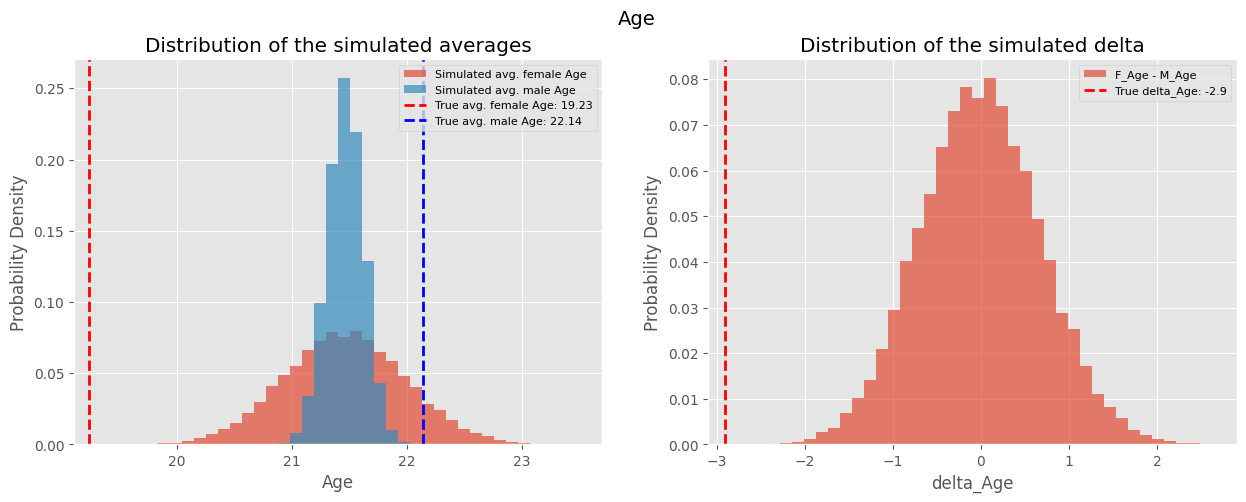

In [ ]:
Permutation_test(df_Invited,20000,'Age')

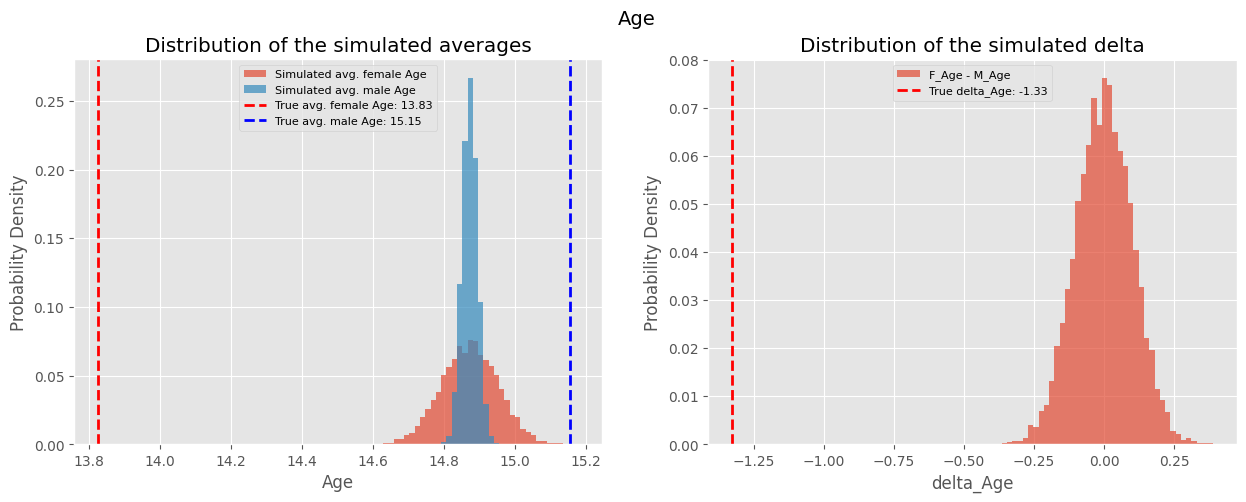

In [ ]:
Permutation_test(df_Proceedings,10000,'Age')

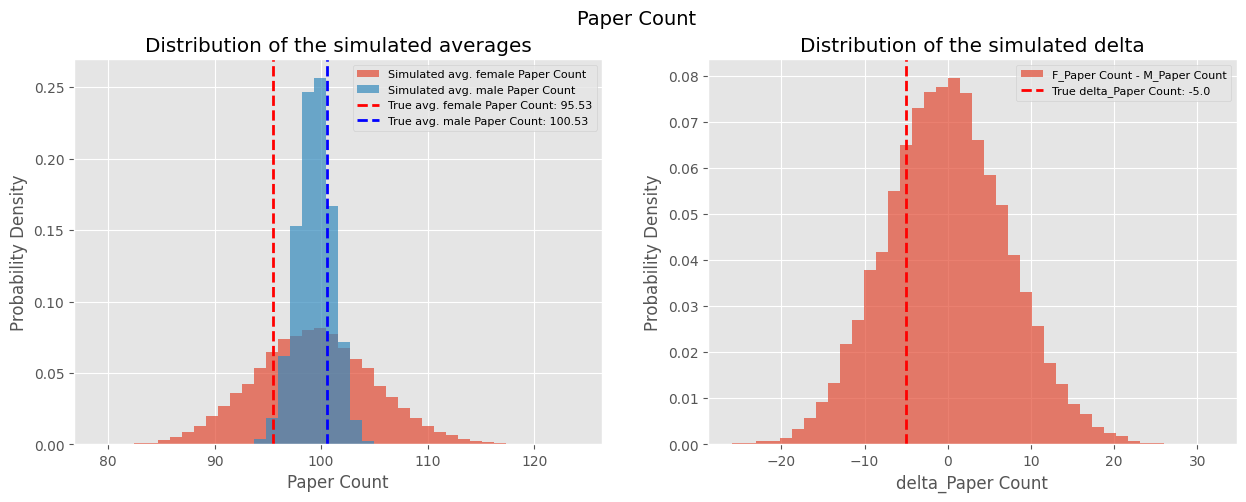

In [ ]:
Permutation_test(df_Invited,20000,'Paper Count')

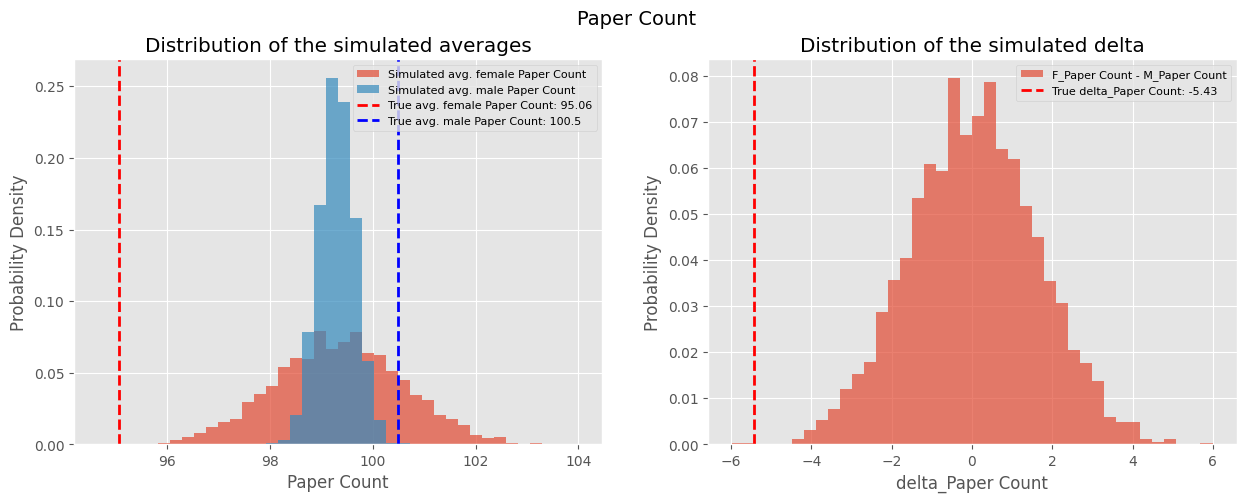

In [ ]:
Permutation_test(df_Proceedings,5000,'Paper Count')

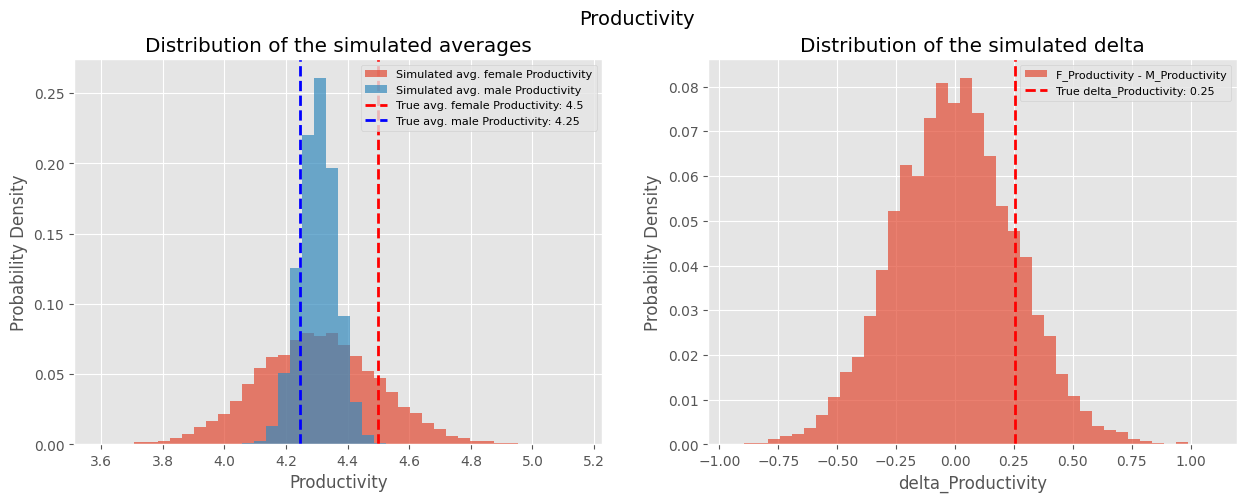

In [ ]:
Permutation_test(df_Invited,10000,'Productivity')

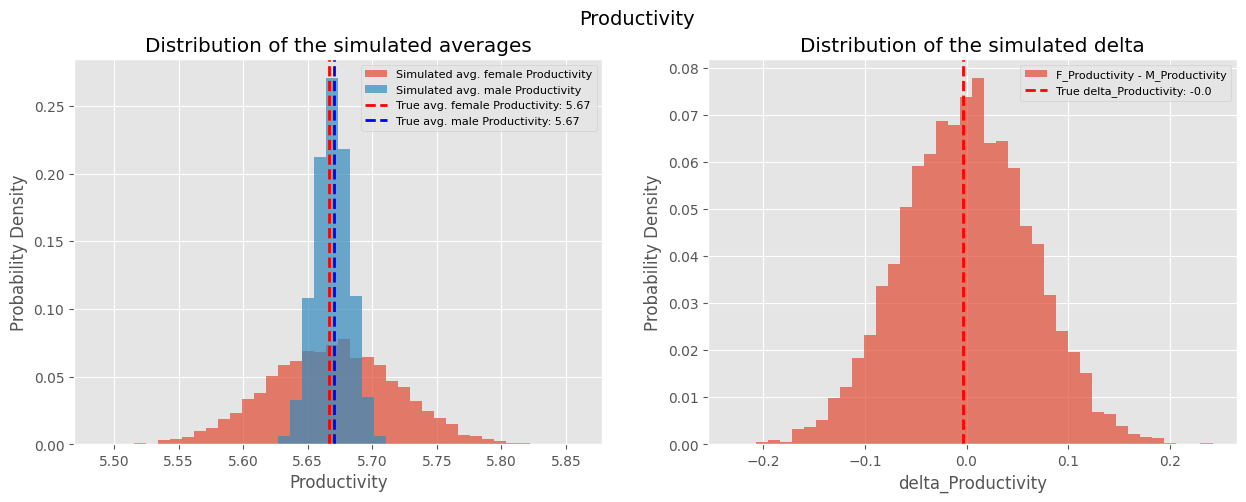

In [ ]:
Permutation_test(df_Proceedings,10000,'Productivity')

## P-Value

<AxesSubplot: title={'center': 'Average productivity per year'}, xlabel='Year'>

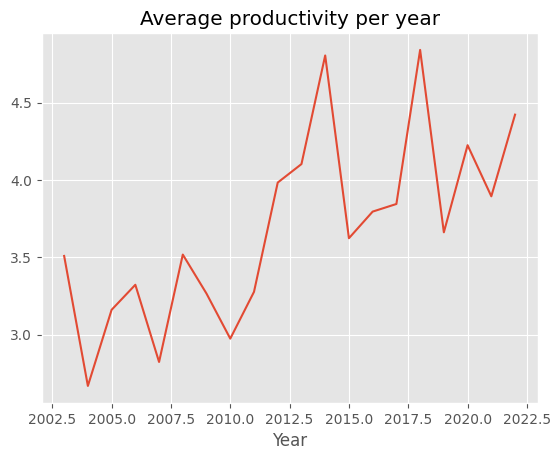

In [39]:
df_Invited.groupby('Year')['Productivity'].mean().plot(title = 'Average productivity per year')

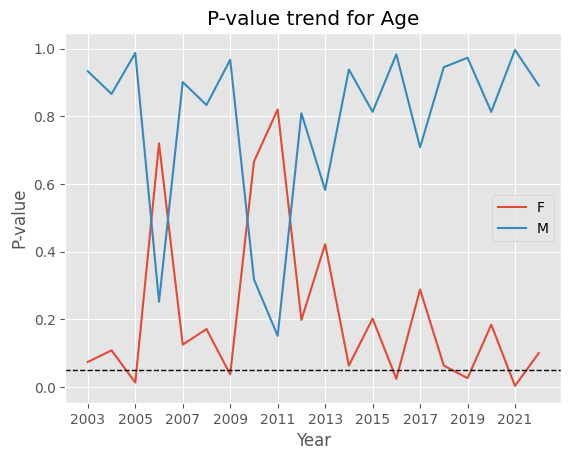

In [100]:
def p_value_trend(df,n,column):
    # Drop all rows with 0 values
    df = df[df[column] != 0]
    df_F = df.groupby('gender').get_group('F')
    df_M = df.groupby('gender').get_group('M')
    
    P_value_F = []
    P_value_M = []
    
    for year in range(2003,2023):
        # Save the true values
        True_avg_F = df_F.groupby('Year')[column].mean()[year]
        True_avg_M = df_M.groupby('Year')[column].mean()[year]
        
        # initialize the lists to store the averages
        avg_F = []
        avg_M = []

        prop_F = df_F.groupby('Year')['Year'].count()[year] / len(df.groupby('Year').get_group(year))
        prop_M = df_M.groupby('Year')['Year'].count()[year] / len(df.groupby('Year').get_group(year))

        df_year = df.groupby('Year').get_group(year)
        
        for i in range(n):
            # randomly assign a new gender to each row
            df_year['gender'] = np.random.choice(['F', 'M'], size=len(df_year), p=[prop_F, prop_M])

            # calculate and store the average value for each gender
            grouped = df_year.groupby('gender')
            avg_F.append(grouped[column].mean().get('F', np.nan))
            avg_M.append(grouped[column].mean().get('M', np.nan))
            
        # count the number of times avg_F is smaller than True_avg_F 
        P_value_F.append(len([x for x in avg_F if x < True_avg_F]) / n)
        P_value_M.append(len([x for x in avg_M if x < True_avg_M]) / n)
    
    ##### plot the P-value trend #####
    plt.plot(range(2003,2023),P_value_F,label='F')
    plt.plot(range(2003,2023),P_value_M,label='M')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('P-value')
    plt.title('P-value trend for '+column)
    plt.xticks(range(2003,2023,2))
    plt.axhline(y=0.05, color='black', linestyle='--',linewidth=1)
    plt.show()


p_value_trend(df_Invited,1000,'Age')